In [29]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import CO2_pre_processing as pre
from pylab import rcParams

# Collect the data
In this section we show how to collect the emissions data for a given time period

In [3]:
collector = CO2DataCollector()

In [4]:
# Collects the data between two boundaries dates
collector.collect_data('2017-01-01', '2020-01-01')

In [5]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2018-2020.csv')

# Data Cleaning
In this section we will perform some data cleaning since there are some corrupted data
that needs to be cleaned to convert the Fecha's column from string to a datetime object

In [2]:
dataset = pandas.read_csv('Emissions_2018-2020.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157680 entries, 0 to 157679
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  157680 non-null  int64  
 1   Fecha       157680 non-null  object 
 2   Emisiones   157680 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ MB


Is there a problem with the data, on certain dates on the interval from 02 to 03, where there are corrupted hours like the following ones:
- 2019-10-27 2A:00
- 2019-10-27 2A:10
- 2019-10-27 2A:20
- 2019-10-27 2A:30
- 2019-10-27 2A:40
- 2019-10-27 2A:50
- 2019-10-27 2B:00
- 2019-10-27 2B:10
- 2019-10-27 2B:20
- 2019-10-27 2B:30
- 2019-10-27 2B:40
- 2019-10-27 2B:50

**Solution:**
- Drop rows which contain the letter 'B' in the Fecha's column
- In the rows where the date contains the characters 2A, replace these with 02

In [4]:
dataset.head()

,Unnamed: 0,Fecha,Emisiones
0,0,2016-12-31 21:00,9659.81
1,1,2016-12-31 21:10,9627.94
2,2,2016-12-31 22:30,9407.57
3,3,2016-12-31 21:20,9562.48
4,4,2016-12-31 21:30,9545.36


In [5]:
# Drop the Unnamed: 0 column
if 'Unnamed: 0' in dataset.columns:
    dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [6]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')
# Use the NOT simbol (~) to return the dataset without these rows
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [7]:
dataset.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00,9659.81
1,2016-12-31 21:10,9627.94
2,2016-12-31 22:30,9407.57
3,2016-12-31 21:20,9562.48
4,2016-12-31 21:30,9545.36
5,2016-12-31 21:50,9442.41
6,2016-12-31 22:10,9514.21
7,2016-12-31 21:40,9494.49
8,2016-12-31 22:20,9448.20
9,2016-12-31 22:00,9420.89


As we can see the dataset is unordered, so in order to sort it we must perform the following tasks:
- Convert the Datetime column 'Fecha' to a datetime object
- Set the Datetime column as the Index
- Sort the dataset by index

In [8]:
# Converts 'Fecha' to datetime object
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])
# Sets the 'Fecha' column as index
dataset = dataset.set_index('Fecha')
# Sort the dataset by index
dataset = dataset.sort_index()

In [9]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


## Creation of alternative dataset
We will create an alternative dataset where the difference between timestamps is one hour, so the emissions will be grouped by hours

In [10]:
# Cretes the new dataset
dataset_freq_1hour = pre.create_dataset_timefreq_1hour(dataset)

In [11]:
dataset_freq_1hour.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97
5,2017-01-01 02:00:00,53940.48
6,2017-01-01 03:00:00,51843.22
7,2017-01-01 04:00:00,50390.88
8,2017-01-01 05:00:00,49331.71
9,2017-01-01 06:00:00,48633.39


## CSV Creation
Now we will create two csv files to store the cleaned dataset. In the first dataset, the difference between timestamps is one hour, while in the second the difference is ten minutes

In [17]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


**Creates 1 hour difference CSV**

In [13]:
# Creates a new CSV with no data errors and ordered rows by date
dataset_freq_1hour.to_csv("2017-2020_Emissions_by_hour_Clean.csv", index=False)

**Creates 10 minutes difference CSV**

In [14]:
# Creates a new CSV with no data errors and ordered rows by date
dataset.to_csv("2017-2020_Emissions_by_10_minutes_Clean.csv")

# Data Analysis

In [3]:
# Read both csv files
dataset_by_10_minutes = pandas.read_csv('2017-2020_Emissions_by_10_minutes_Clean.csv')
dataset_by_hour = pandas.read_csv('2017-2020_Emissions_by_hour_Clean.csv')

CSV files cannot cannot save datetime objects and saves the rows unordered, so each time we read a CSV file, we must
to perform the following tasks:
- Convert 'Fecha' column to datetime object
- Set 'Fecha' column as the new index
- Sort the dataset by DateTime Index

In [5]:
# This function perform the tasks above
dataset_by_10_minutes = pre.prepare_timeseries_dataset(dataset_by_10_minutes, 0)
dataset_by_hour = pre.prepare_timeseries_dataset(dataset_by_hour, 0)

In [6]:
dataset_by_10_minutes.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49
2016-12-31 21:50:00,9442.41
2016-12-31 22:00:00,9420.89
2016-12-31 22:10:00,9514.21
2016-12-31 22:20:00,9448.20


In [7]:
dataset_by_hour.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,57332.49
2016-12-31 22:00:00,56671.33
2016-12-31 23:00:00,57666.70
2017-01-01 00:00:00,57684.04
2017-01-01 01:00:00,56670.97
2017-01-01 02:00:00,53940.48
2017-01-01 03:00:00,51843.22
2017-01-01 04:00:00,50390.88
2017-01-01 05:00:00,49331.71


## Resample the dataset
In this section we will try to resample the dataset in order to obtain the mean of emissions for each month and decompose it to analyze
the trend and seasonality

In [21]:
dataset_by_hour.index

DatetimeIndex(['2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00',
               '2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               ...
               '2019-12-31 11:00:00', '2019-12-31 12:00:00',
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=26280, freq='H')

If we look the frequency of our dataset, it is set to None, so we will have to infer it in order to resample the dataset

In [19]:
# Converts the dataset into a frequency of 1 hour, it doesn't change the data because it already have a frequency of 1 hour
dataset_by_hour = dataset_by_hour.asfreq('H')

Now we will try to resample the dataset to a monthly frequency and the mean of emissions

In [22]:
dataset_by_month = dataset_by_hour['Emisiones'].resample('MS').mean()

In [23]:
dataset_by_month.head(10)

Fecha
2016-12-01    57223.506667
2017-01-01    61563.583347
2017-02-01    46414.701845
2017-03-01    29037.953513
2017-04-01    24765.413931
2017-05-01    38081.439140
2017-06-01    50720.670472
2017-07-01    49045.904637
2017-08-01    39786.750027
2017-09-01    40026.869500
Freq: MS, Name: Emisiones, dtype: float64

In [25]:
# Check if some missing values have been created because of resampling
dataset_by_month.isnull().sum()

0

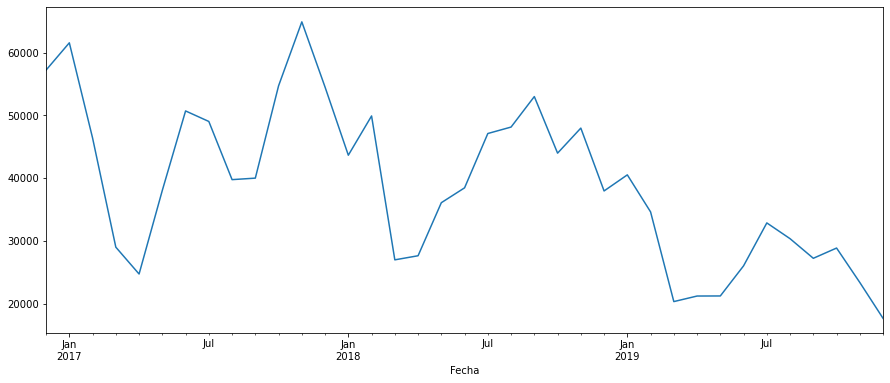

In [24]:
dataset_by_month.plot(figsize=(15, 6))
pyplot.show()

Looking the data we can form some hypotheses:
- It has a decreasing trend, maybe caused by some energy related politics which improve the use of renovables energies through the years
- It shows a seasonality pattern, from January to April emissions decrease greatly, then from April to December they increases to the peak but with some decreasing in September or October.

## Decompose the series

Now we will decompose the series into an additive or multiplicative series.

**Additive Series:**
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Series:**
Value = Base Level * Trend * Seasonality * Error

If our dataset would not have a specific frequency, we would have to add the period parameter

In [26]:
# Multiplicative Decomposition
result_mul = seasonal_decompose(dataset_by_month, model='multiplicative')
# Additive Decomposition
result_add = seasonal_decompose(dataset_by_month, model='additive')

In [30]:
# Set the figsize
rcParams['figure.figsize'] = 11, 9

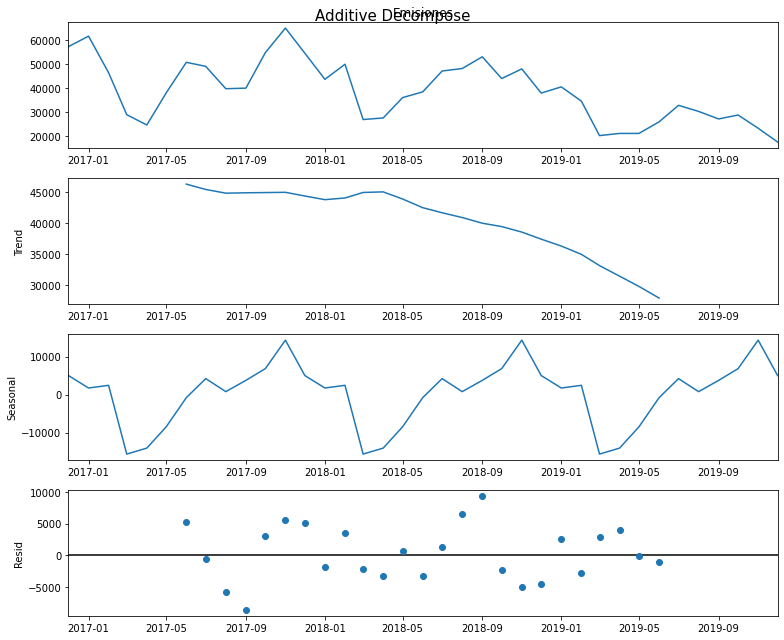

In [31]:
# Plot additive decomposition
result_add.plot().suptitle('Additive Decompose', fontsize=15)
pyplot.show()

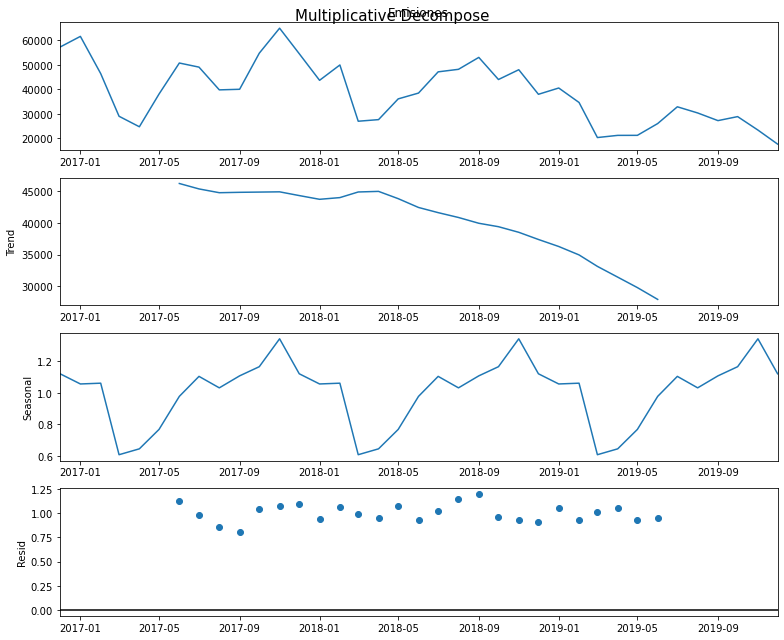

In [32]:
# Plot multiplicative decomposition
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15)
pyplot.show()

# Prophet model

In [17]:
prophet = Prophet()

In [21]:
dataset = dataset.rename(columns={"Fecha": "ds", "Emisiones": "y"})

In [22]:
dataset.head()

,ds,y
Unnamed: 0,,
0,2016-12-31 21:00:00,9659.81
1,2016-12-31 21:10:00,9627.94
2,2016-12-31 22:30:00,9407.57
3,2016-12-31 21:20:00,9562.48
4,2016-12-31 21:30:00,9545.36


In [ ]:
prophet.fit(dataset)

In [ ]:
future = prophet.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = prophet.plot(forecast)